# Exploring Wikipedia in a Temporal Fashion
Authors: Felix Borum Burmester & Christian Vestergaard Djurhuus.

In this notebook, we will explore the temporal development of Marvel- and DC-Comics. We have used the Wikipedia Revisions api to scrape the Wikipedia pages of 2303 superheroes since the dawn of Wikipedia. We have used these pages to create a directed, temporal graph object that will allow us to understand the development of revisions.

We have also webscraped meta data from lists of female, black, latino, and asian superheroes and villains. With this meta data we were able to appoint node attributes to our graph with the help of document similarity (since different websites may call superheroes by different versions of their names).

<img src="G_plot_final.gif" width="750" align="center">

The red nodes here are Marvel characters, and the blue are DC characters!

Let's explore the data and its attributes!

## Exploration of Basic Stats in Network
### Node Analysis
Let's view the number of nodes with each label by time:

In [3]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#import data
meta_df = pd.read_csv('metadataproject.csv')
edgelist = pd.read_csv('corrected_edgelist.csv')

In [4]:
meta_df.head()

,Unnamed: 0,CharacterName,WikiLink,universe,asian,latino,woman,black,man,good,bad
0,0,Abomination,Abomination (character),Marvel,0,0,0,0,1,0,1
1,1,Absorbing Man,Absorbing Man,Marvel,0,0,0,0,1,0,1
2,2,Achebe,Achebe (comics),Marvel,0,0,0,0,0,0,0
3,3,Agent,Agent (comics),Marvel,0,0,0,0,1,1,0
4,4,Agent X,Agent X (Marvel Comics),Marvel,0,0,0,0,1,1,0


As you can see, there is not meta data for all nodes; Achebe has no gender, race or alignment in our data..

In [5]:
edgelist.head()

,source,target,timestamp
0,Abomination (character),Silver Surfer,2014
1,Abomination (character),Thor (Marvel Comics),2014
2,Abomination (character),Sprocket (comics),2014
3,Abomination (character),Glenn Talbot,2014
4,Abomination (character),MODOK,2014


The edgelist has timestamps for when the link is valid. This is used to later create time-specific snapshots of the graph!

Now we create a node list and merge it with our meta data

In [7]:
sourcenodes = pd.DataFrame(np.array(list(edgelist.groupby(['source','timestamp']).groups.keys())), columns = ['node','timestamp'])
targetnodes = pd.DataFrame(np.array(list(edgelist.groupby(['target','timestamp']).groups.keys())), columns = ['node','timestamp'])
#keep unique nodes and timestamps!
nodes =  pd.concat([sourcenodes,targetnodes]).drop_duplicates().reset_index(drop=True)

temp = meta_df.rename(columns={'WikiLink':'node'})
nodes = pd.merge(nodes, temp, on="node")
nodes = nodes.drop(columns=['Unnamed: 0'])
nodes.head()

,node,timestamp,CharacterName,universe,asian,latino,woman,black,man,good,bad
0,3-D Man,2007,3-D Man,Marvel,0,0,0,0,1,1,0
1,3-D Man,2008,3-D Man,Marvel,0,0,0,0,1,1,0
2,3-D Man,2009,3-D Man,Marvel,0,0,0,0,1,1,0
3,3-D Man,2010,3-D Man,Marvel,0,0,0,0,1,1,0
4,3-D Man,2011,3-D Man,Marvel,0,0,0,0,1,1,0


We need some pd.series to plot, so we use groupby and its features to get them and create three plots:

In [8]:
#get plotable data for marvel and dc
total_nodes_by_year = nodes.groupby('timestamp').size()
temp = nodes.groupby(['universe'])
dc_nodes_by_year, marvel_nodes_by_year = [temp.get_group(x) for x in temp.groups]
dc_nodes_by_year = dc_nodes_by_year.groupby('timestamp').size()
marvel_nodes_by_year = marvel_nodes_by_year.groupby('timestamp').size()

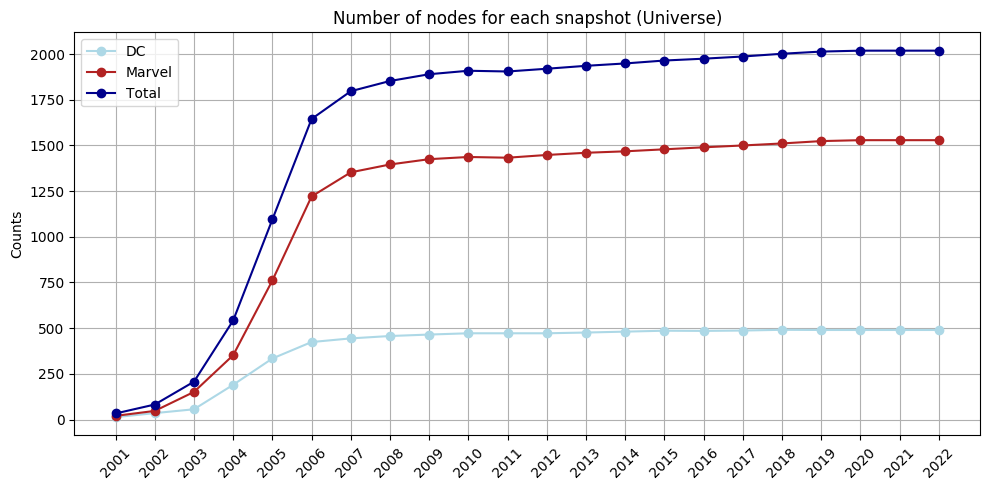

In [9]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(dc_nodes_by_year.index, dc_nodes_by_year.values, '-o', c='lightblue', label='DC')
ax.plot(marvel_nodes_by_year.index, marvel_nodes_by_year.values, '-o', c='firebrick', label='Marvel')
ax.plot(total_nodes_by_year.index, total_nodes_by_year.values, '-o', c='darkblue',label='Total')
ax.set_title("Number of nodes for each snapshot (Universe)")
ax.set_ylabel("Counts")
ax.grid()
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We see here that there is a surge in number of nodes from 2003 to 2007 where it looks like it is more stable with a slight upwards trend. This might overshadow further analysis of the graph. One might consider making a cut and only view the data from 2007 to 2022.

Let's view some other features in the data!

In [10]:
#get plotable data for sex, race and alignment!
temp = nodes.groupby(['man'])
man_nodes_by_year = [temp.get_group(x) for x in temp.groups][1].groupby('timestamp').size()
temp = nodes.groupby(['woman'])
woman_nodes_by_year = [temp.get_group(x) for x in temp.groups][1].groupby('timestamp').size()
temp = nodes.groupby(['asian'])
asian_nodes_by_year = [temp.get_group(x) for x in temp.groups][1].groupby('timestamp').size()
temp = nodes.groupby(['latino'])
latino_nodes_by_year = [temp.get_group(x) for x in temp.groups][1].groupby('timestamp').size()
temp = nodes.groupby(['black'])
black_nodes_by_year = [temp.get_group(x) for x in temp.groups][1].groupby('timestamp').size()
temp = nodes.groupby(['good'])
good_nodes_by_year = [temp.get_group(x) for x in temp.groups][1].groupby('timestamp').size()
temp = nodes.groupby(['bad'])
bad_nodes_by_year = [temp.get_group(x) for x in temp.groups][1].groupby('timestamp').size()

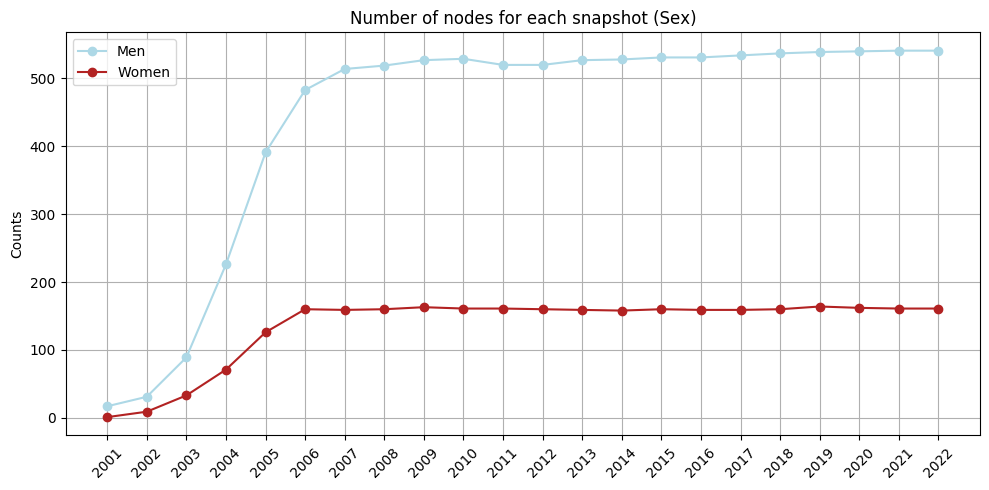

In [25]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(man_nodes_by_year.index, man_nodes_by_year.values, '-o', c='lightblue', label='Men')
ax.plot(woman_nodes_by_year.index, woman_nodes_by_year.values, '-o', c='firebrick', label='Women')
ax.set_title("Number of nodes for each snapshot (Sex)")
ax.set_ylabel("Counts")
ax.grid()
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The same surge-trend seems to be present here as well. There is no indication from this plot that wokeism have created more superheroine wikipedia articles at least. Let's see the same plot with everything pre 2007 cut off:

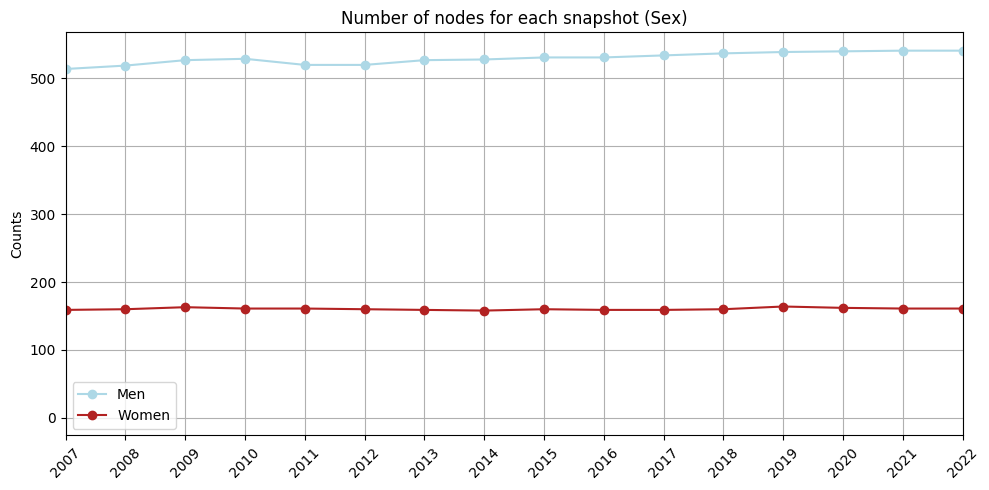

In [27]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(man_nodes_by_year.index, man_nodes_by_year.values, '-o', c='lightblue', label='Men')
ax.plot(woman_nodes_by_year.index, woman_nodes_by_year.values, '-o', c='firebrick', label='Women')
ax.set_title("Number of nodes for each snapshot (Sex)")
ax.set_ylabel("Counts")
ax.grid()
ax.legend()
plt.xlim('2007','2022')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Our verdict does not change.. But what about race?

It was not possible to find any list of caucasian superheroes or villains. You might be able to conclude that the rest are white, but as some superheroes or villains are aliens, it would not be correct to assume them to be white. "Why not find a list of extraterestial superheroes?" Well, Thor, Loki and Odin are extraterestial but they are also caucasian. We found it best not to mess with this as the data would be highly inaccurate.

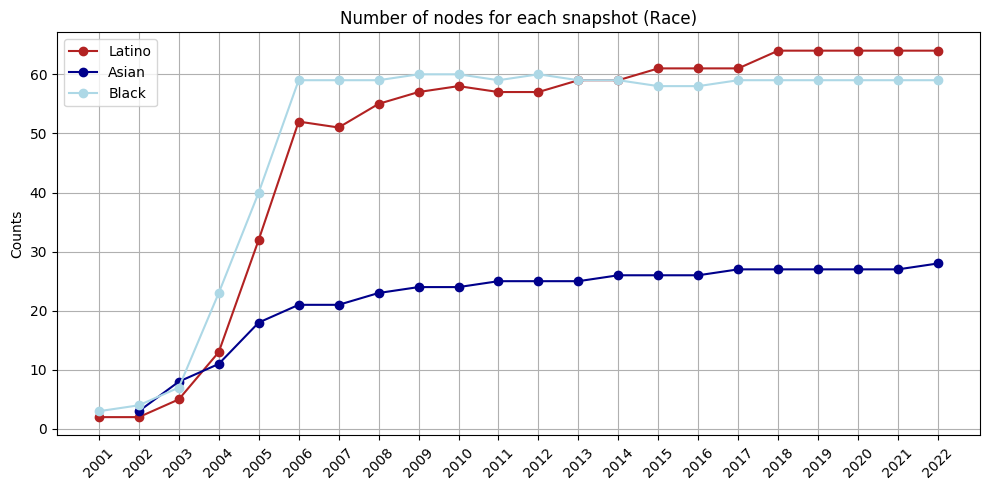

In [28]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(latino_nodes_by_year.index, latino_nodes_by_year.values, '-o', c='firebrick', label='Latino')
ax.plot(asian_nodes_by_year.index, asian_nodes_by_year.values, '-o', c='darkblue',label='Asian')
ax.plot(black_nodes_by_year.index, black_nodes_by_year.values, '-o', c='lightblue',label='Black')
ax.set_title("Number of nodes for each snapshot (Race)")
ax.set_ylabel("Counts")
ax.grid()
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Here we see some interesting trends. The number of Wiki articles for Latinos and Asians seem to steadily increase while Black superhero articles seem to decline. Perhaps this is worth further exploration in the project?

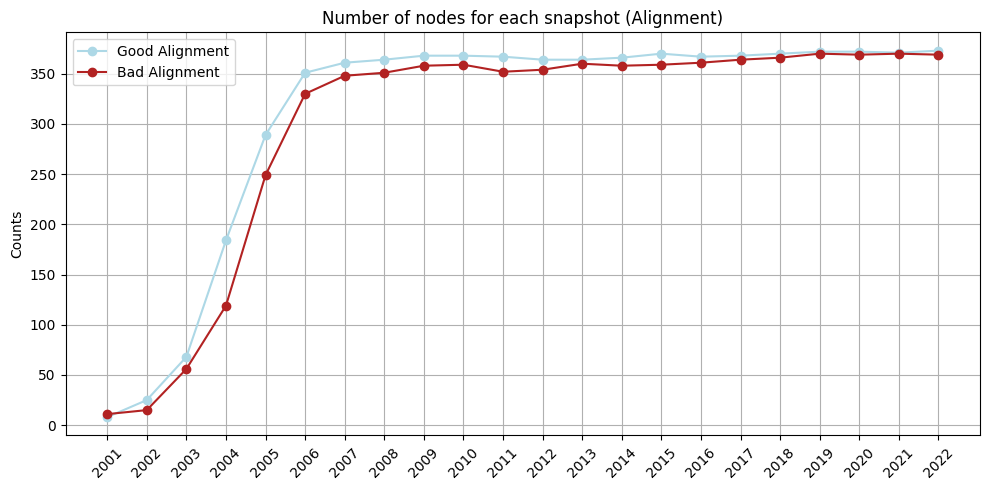

In [29]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(good_nodes_by_year.index, good_nodes_by_year.values, '-o', c='lightblue', label='Good Alignment')
ax.plot(bad_nodes_by_year.index, bad_nodes_by_year.values, '-o', c='firebrick',label='Bad Alignment')
ax.set_title("Number of nodes for each snapshot (Alignment)")
ax.set_ylabel("Counts")
ax.grid()
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It makes sense that there would be about the same number of superheros as super villains (and that the trends would follow each other closely).

All plots of nodes seem to follow the general Wikipedia trend ([with the massive surge in 2003-2006](https://en.wikipedia.org/wiki/Wikipedia:Statistics)). It is still interesting that there have been a lot more pages created on male superheroes as compared to female superheroes in general. This could indicate that there are more male superheroes to create articles about and that the ones creating articles are more interested in them (perhaps because they are males themselves).

### Edge Analysis
The number of nodes seem to follow the same general trend, but might the number of edges be different?

### Node Degree Analysis
Let's first view the average degree of nodes in the graph at each timestep to determine if this follows the same trend as the edge analysis:

In [30]:
#create edgelist for each year
import networkx as nx
import numpy as np
edgelist_divided = {}
groups = edgelist.groupby('timestamp').groups
for key, index in groups.items():
    edgelist_divided[key] = edgelist.loc[index]

In [32]:
#we will load in the graph from a list of gml files
#as setting node attributes takes a while 
#(and does not look pretty)
graphs = {}
for key in np.arange(2001,2023,1):
    graphs[key] = nx.read_gml(f'graphs/DG_{key}')

In [35]:
#Calculate degrees
avg_degrees = {}
for key in graphs.keys():
    avg_degrees[key] = sum([graphs[key].in_degree(x) for x in graphs[key].nodes()])/graphs[key].number_of_nodes()

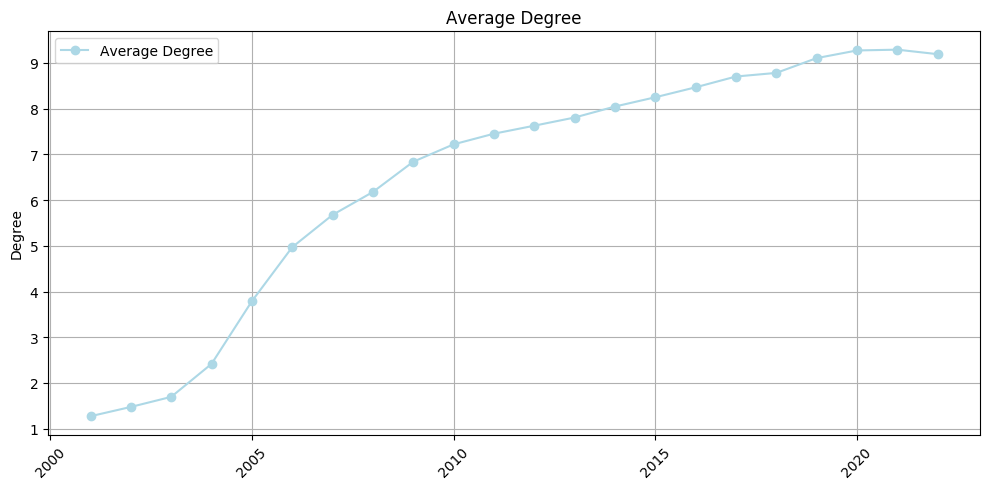

In [36]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(list(avg_degrees.keys()), list(avg_degrees.values()), '-o', c='lightblue', label='Average Degree')
ax.set_title("Average Degree")
ax.set_ylabel("Degree")
ax.grid()
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It follows the exact same trend as the number of edges as expected. This is pretty obvious if you think about it since node degree is dependent on the number of edges it has, buuut it's nice to know for a fact xD

### Do the Graphs Differ from Random Graphs?
To answer this, we will perform some permutation tests.

> * First, we will shift the links (using an edge swap algorithm) between nodes and measure average node centrality.
> * Second, we will shift the labels of the nodes and again measure average node centrality between groups (Sex, Universe, Race and Alignment)

Let's get to it!

In [37]:
import random
# Define our double edge swap algorithm (taken from a previous course)
def double_edge_swap(G: nx.DiGraph, N: int)->nx.DiGraph:
    '''
    First we choose random nodes. After that we choose to search edges through the neighbors as we assume
    that the number of neighbors is much smaller than the entire edge list, especially for large
    scale networks. This is the way!
    '''
    G_random = G.copy()
    num_swaps = 0
    edges = list(G_random.edges) #Define edges out of the loop. No need to update them!
    while num_swaps < N:
        (u,_), (x,_) = random.choices(edges, k=2) #Draw source nodes
        
        if u==x: #Same source 
            continue
        
        u_neighbors = list(G_random.neighbors(u))
        x_neighbors = list(G_random.neighbors(x))
        
        v = random.choices(u_neighbors)[0] #Draw target nodes
        y = random.choices(x_neighbors)[0]
        
        if v==y: #Same target
            continue

        if (x not in G_random.neighbors(u)) and (y not in G_random.neighbors(v)):
            G_random.add_edge(u, x) 
            G_random.add_edge(v, y)
            G_random.remove_edge(u, v) 
            G_random.remove_edge(x, y)
            num_swaps += 1
    return G_random 

In [41]:
number_of_swapped_graphs = 50
#we could change this number but it takes quite a while
#to run this as it has to be done for 22 graphs as well
#to get the temporal aspect.

#while we are at it, lets get some tqdm to see if we can
#get coffee while we run it :D
from tqdm import tqdm

In [42]:
dist_to_quantiles = []
for key,value in tqdm(graphs.items()):
    node_cen = []
    true_node_cen = np.mean(list(dict(nx.degree_centrality(value)).values()))
    for i in range(number_of_swapped_graphs):
        G_random = double_edge_swap(value.to_undirected(),nx.number_of_edges(value)+1000)
        node_cen.append(np.mean(list(dict(nx.degree_centrality(G_random)).values())))
    node_cen_quantiles = np.percentile(node_cen,95)
    dist_to_quantiles.append(true_node_cen-node_cen_quantiles)

100%|██████████| 22/22 [03:57<00:00, 10.78s/it]


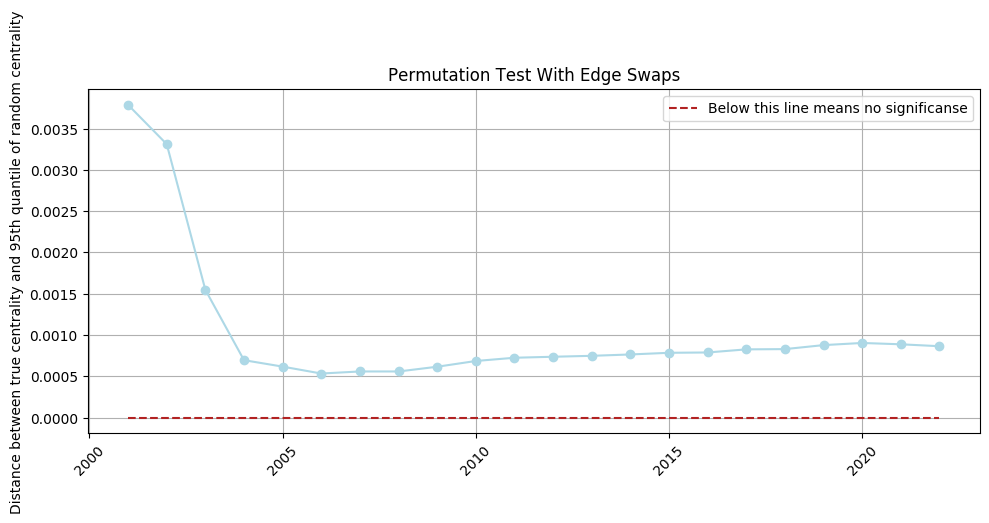

In [45]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(np.arange(2001,2023,1), dist_to_quantiles, '-o', c='lightblue')
ax.set_title("Permutation Test With Edge Swaps")
ax.set_ylabel("Distance between true centrality and 95th quantile of random centrality")
ax.plot(np.arange(2001,2023,1), np.zeros(22), '--',c='firebrick', label = 'Below this line means no significanse')
ax.grid()
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

So you might be wondering what exactly this graph shows. The blue line shows the distance between our true graph's average node centrality and the 95th quantile of our random graphs' node centrality. As long as this is above 0 (or the dashed red line), our true graph's average node centrality is significantly different from that of a random network's!

As you can see, we do not cross the dashed line ever; our graph is significantly different from a random one!

What about a label swap? Let's see:

In [47]:
#testing universe attribute
marvel_centralities = []
dc_centralities = []
for key, value in tqdm(graphs.items()):
    centrality = nx.degree_centrality(value)
    true_centrality = np.percentile(list(centrality.values()),95)
    G_random = value.copy()
    for _ in range(50):
        labels = list(nx.get_node_attributes(value, "Universe").values())
        random_labels = random.sample(labels, len(labels))
        values = dict(zip(value.nodes,random_labels))

        nx.set_node_attributes(G_random, values, name="random group")

        universe = nx.get_node_attributes(G_random, "random group")
        uni_centrality = {}
        for u,v in centrality.items():
            try:
                uni_centrality[universe[u]] += [v]
            except KeyError:
                uni_centrality[universe[u]] = [v]

    marvel_centralities.append(true_centrality-np.mean(np.mean(list(uni_centrality['Marvel']))))
    dc_centralities.append(true_centrality-np.mean(np.mean(list(uni_centrality['DC']))))

100%|██████████| 22/22 [00:03<00:00,  6.42it/s]


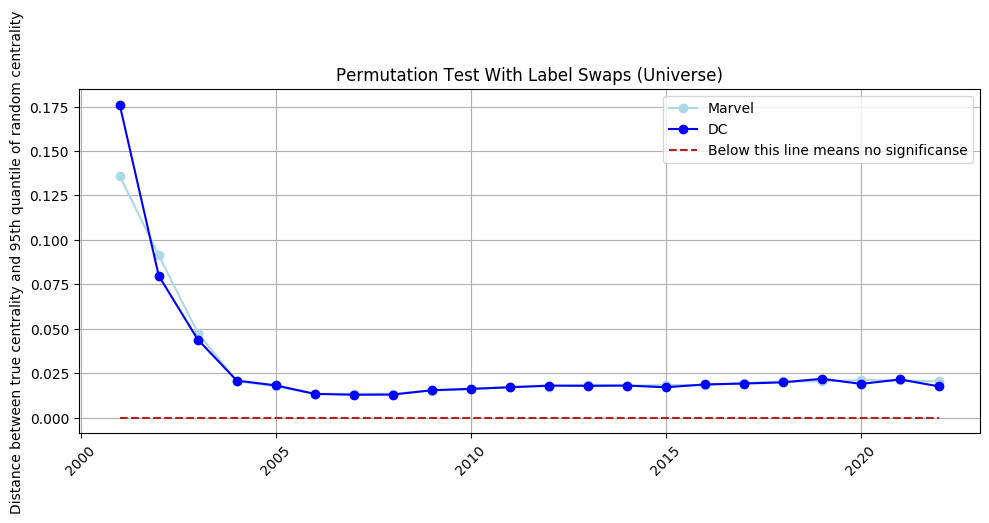

In [48]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(np.arange(2001,2023,1), marvel_centralities, '-o', c='lightblue',label='Marvel')
ax.plot(np.arange(2001,2023,1), dc_centralities, '-o', c='blue',label='DC')
ax.set_title("Permutation Test With Label Swaps (Universe)")
ax.set_ylabel("Distance between true centrality and 95th quantile of random centrality")
ax.plot(np.arange(2001,2023,1), np.zeros(22), '--',c='firebrick', label = 'Below this line means no significanse')
ax.grid()
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The universe attributes are not random. Let's see the gender attribute:

In [50]:
#test on gender attribute
Male_centralities = []
Female_centralities = []
for key, value in tqdm(graphs.items()):
    centrality = nx.degree_centrality(value)
    true_centrality = np.percentile(list(centrality.values()),95)
    G_random = value.copy()
    for _ in range(50):
        labels = list(nx.get_node_attributes(value, "Sex").values())
        random_labels = random.sample(labels, len(labels))
        values = dict(zip(value.nodes,random_labels))

        nx.set_node_attributes(G_random, values, name="random group")

        universe = nx.get_node_attributes(G_random, "random group")
        uni_centrality = {}
        for u,v in centrality.items():
            try:
                uni_centrality[universe[u]] += [v]
            except KeyError:
                uni_centrality[universe[u]] = [v]

    Male_centralities.append(true_centrality-np.mean(np.mean(list(uni_centrality['Male']))))
    Female_centralities.append(true_centrality-np.mean(np.mean(list(uni_centrality['Female']))))

100%|██████████| 22/22 [00:03<00:00,  5.96it/s]


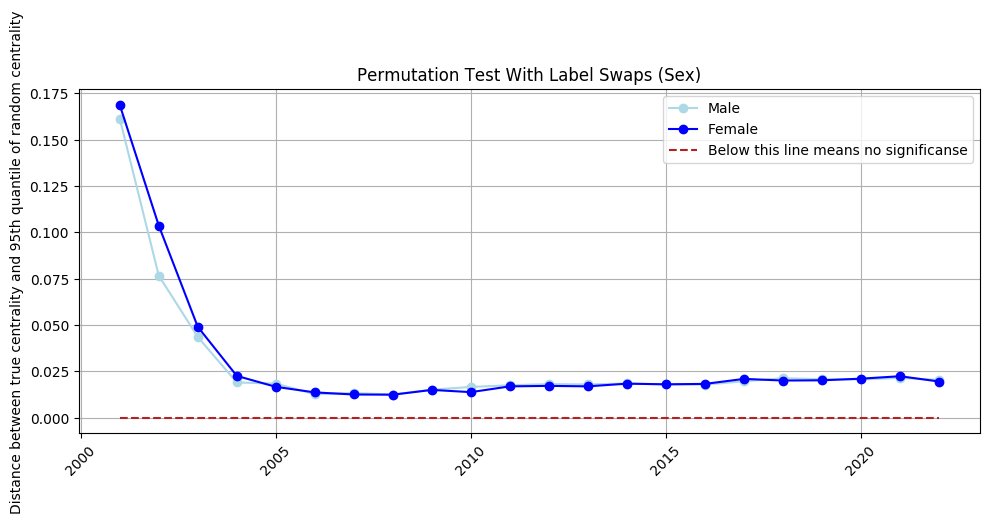

In [51]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(np.arange(2001,2023,1), Male_centralities, '-o', c='lightblue',label='Male')
ax.plot(np.arange(2001,2023,1), Female_centralities, '-o', c='blue',label='Female')
ax.set_title("Permutation Test With Label Swaps (Sex)")
ax.set_ylabel("Distance between true centrality and 95th quantile of random centrality")
ax.plot(np.arange(2001,2023,1), np.zeros(22), '--',c='firebrick', label = 'Below this line means no significanse')
ax.grid()
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We don't see any timestamp with random gender attributes either. Race?

In [55]:
#test on race attribute
Black_centralities = []
Asian_centralities = []
Latino_centralities = []
for key, value in tqdm(graphs.items()):
    centrality = nx.degree_centrality(value)
    true_centrality = np.percentile(list(centrality.values()),95)
    G_random = value.copy()
    for _ in range(50):
        labels = list(nx.get_node_attributes(value, "Race").values())
        random_labels = random.sample(labels, len(labels))
        values = dict(zip(value.nodes,random_labels))

        nx.set_node_attributes(G_random, values, name="random group")

        universe = nx.get_node_attributes(G_random, "random group")
        uni_centrality = {}
        for u,v in centrality.items():
            try:
                uni_centrality[universe[u]] += [v]
            except KeyError:
                uni_centrality[universe[u]] = [v]

    Black_centralities.append(true_centrality-np.mean(np.mean(list(uni_centrality['Black']))))
    try:
        Asian_centralities.append(true_centrality-np.mean(np.mean(list(uni_centrality['Asian']))))
    except:
        pass
    Latino_centralities.append(true_centrality-np.mean(np.mean(list(uni_centrality['Latino']))))

100%|██████████| 22/22 [00:03<00:00,  6.39it/s]


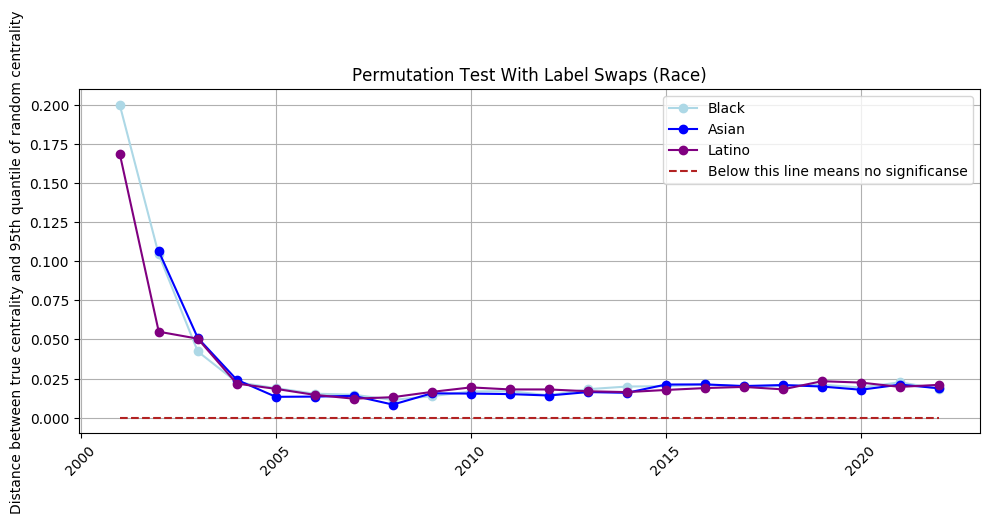

In [59]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(np.arange(2001,2023,1), Black_centralities, '-o', c='lightblue',label='Black')
ax.plot(np.arange(2002,2023,1), Asian_centralities, '-o', c='blue',label='Asian')
ax.plot(np.arange(2001,2023,1), Latino_centralities, '-o', c='purple',label='Latino')
ax.set_title("Permutation Test With Label Swaps (Race)")
ax.set_ylabel("Distance between true centrality and 95th quantile of random centrality")
ax.plot(np.arange(2001,2023,1), np.zeros(22), '--',c='firebrick', label = 'Below this line means no significanse')
ax.grid()
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Neither race is random. It is interesting that there is no Asian superheroes in 2001 by the way.

Finally, we have good and bad alignment:

In [61]:
#test on alignment attribute
Good_centralities = []
Bad_centralities = []
for key, value in tqdm(graphs.items()):
    centrality = nx.degree_centrality(value)
    true_centrality = np.percentile(list(centrality.values()),95)
    G_random = value.copy()
    for _ in range(50):
        labels = list(nx.get_node_attributes(value, "Alignment").values())
        random_labels = random.sample(labels, len(labels))
        values = dict(zip(value.nodes,random_labels))

        nx.set_node_attributes(G_random, values, name="random group")

        universe = nx.get_node_attributes(G_random, "random group")
        uni_centrality = {}
        for u,v in centrality.items():
            try:
                uni_centrality[universe[u]] += [v]
            except KeyError:
                uni_centrality[universe[u]] = [v]

    Good_centralities.append(true_centrality-np.mean(np.mean(list(uni_centrality['Good']))))
    Bad_centralities.append(true_centrality-np.mean(np.mean(list(uni_centrality['Bad']))))

100%|██████████| 22/22 [00:03<00:00,  5.86it/s]


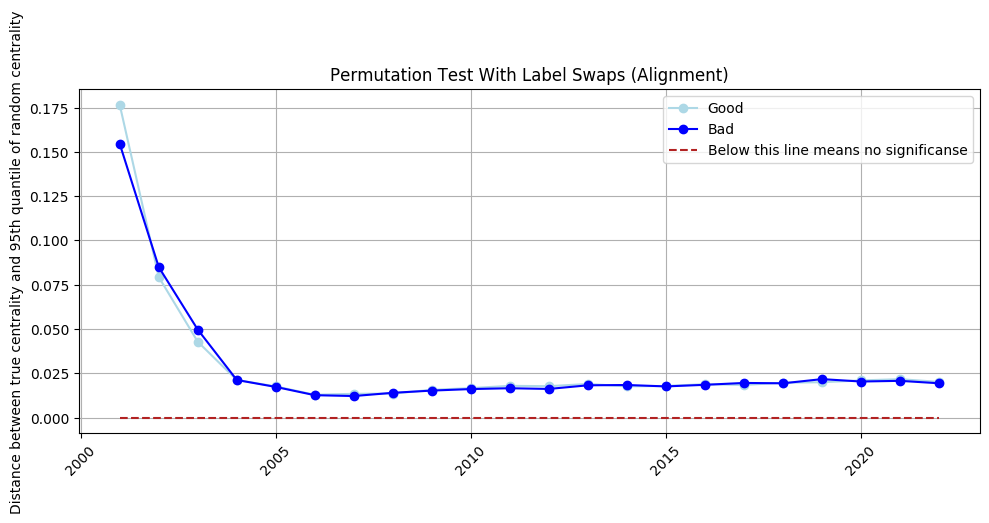

In [63]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(np.arange(2001,2023,1), Good_centralities, '-o', c='lightblue',label='Good')
ax.plot(np.arange(2001,2023,1), Bad_centralities, '-o', c='blue',label='Bad')
ax.set_title("Permutation Test With Label Swaps (Alignment)")
ax.set_ylabel("Distance between true centrality and 95th quantile of random centrality")
ax.plot(np.arange(2001,2023,1), np.zeros(22), '--',c='firebrick', label = 'Below this line means no significanse')
ax.grid()
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Again there is no insignificanse.

To sum up; the graph is by no means random neither the communities nor the labels.

### Clusters! How Do They Evolve?
In this section we will test two hypotheses:
> * The network grows in a "coral-growth" pattern. 
>  - This will be tested by running an InfoMap Ensemble algorithm to determine communities in the graph at $t_n$. Then we will create a heatmap showing when nodes are added to each community to see whether they are added in a coral pattern - meaning that nodes within the same community are added at the same time. Spoiler alert: We will try to find an even cooler way to show this during our project!
> * Show how communities share nodes throughout the time period.
>  - How?

In [64]:
from community import community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

G = graphs[2022].copy().to_undirected()

# split into marvel and DC
marvel = []
dc = []
for key, value in nx.get_node_attributes(G,'Universe').items():
    if value == 'Marvel':
        marvel.append(key)
    elif value == 'DC':
        dc.append(key)

G_marvel = G.subgraph(marvel)
G_dc = G.subgraph(dc)

#Keep only largest component
G_marvel = G_marvel.subgraph(sorted(nx.connected_components(G_marvel), key=len, reverse=True)[0])
G_dc = G_dc.subgraph(sorted(nx.connected_components(G_dc), key=len, reverse=True)[0])

# compute the best partition
partition_marvel = community_louvain.best_partition(G_marvel)
partition_dc = community_louvain.best_partition(G_dc)


dc_pss = {}
marvel_pss = {}
for key in graphs.keys():
    dc_ps = []
    marvel_ps = []
    for node in graphs[key].nodes():
        try:
            graphs[key-1].nodes()[node]
            continue
        except:
            pass
        try:
            p_number_marvel = partition_marvel[node]
            marvel_ps.append(p_number_marvel)
        except:
            try:
                p_number_dc = partition_dc[node]
                dc_ps.append(p_number_dc)
            except:
                continue
    dc_pss[key] = dc_ps
    marvel_pss[key] = marvel_ps

from collections import Counter

dc_counts = {}
for key, value in dc_pss.items():
    dc_counts[key] = Counter(value)
marvel_counts = {}
for key, value in marvel_pss.items():
    marvel_counts[key] = Counter(value)

In [140]:
#number of communities shown
n_communities=len(n_marvel_communities) + len(n_dc_communities)

In [164]:
partition_matrix = np.zeros((n_communities,22))
count = 0
for key, value in dc_counts.items():
    for key2, value2 in value.items():
        partition_matrix[key2+len(n_marvel_communities),count] = value2
    count += 1
count = 0
for key, value in marvel_counts.items():
    for key2, value2 in value.items():
        partition_matrix[key2,count] = value2
    count += 1

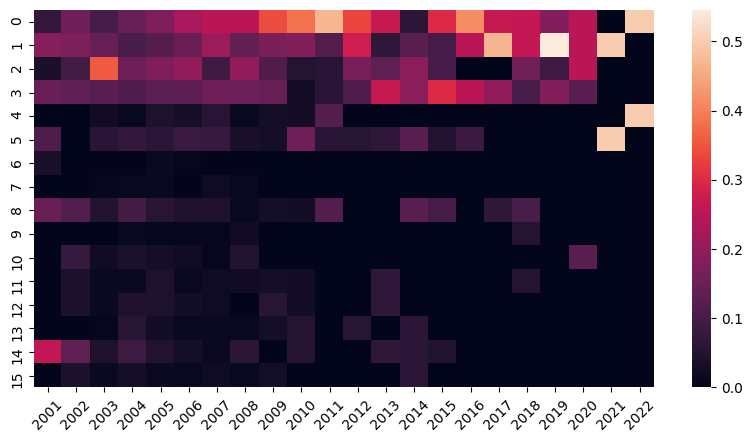

In [165]:
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import normalize

#normalize rows of matrix
partition_matrix_normalised = normalize(partition_matrix, axis=0, norm='l1')

fig, ax = plt.subplots(figsize=(10,5), dpi=100)
df_partition_matrix_normalised = pd.DataFrame(partition_matrix_normalised, index = np.arange(0,n_communities,1),
                  columns = [i for i in graphs.keys()])
sns.heatmap(df_partition_matrix_normalised)
plt.xticks(rotation=45)
plt.show()

This is normalised by years (columns) therefore, whenever we have a high value, we see that most of the nodes added that year was added to that community. Especially in the later years we do see a form of coral-growth.

We can also see the node with the highest degree in these communities to separate them from one another: (scroll a bit for a nice gif, else you can scroll through the output of the plotting cell to see in depth)

In [166]:
# get community names (largest degree node in each community)
n_marvel_communities = np.unique(list(partition_marvel.values()))
n_dc_communities = np.unique(list(partition_dc.values()))
d = dict(graphs[2022].degree())
sorted_degrees = {k: d[k] for k in sorted(d, key=d.get, reverse=True)}

community_names = {}
for key,value in sorted_degrees.items():
    try:
        com = partition_marvel[key]
        try:
            community_names[com]
        except:
            community_names[com] = key
    except:
        try:
            com = partition_dc[key]
            try:
                connumity_names[com]
            except:
                community_names[com+len(n_marvel_communities)] = key
        except:
            continue
    if len(community_names)==n_communities:
        break

In [217]:
def gen_colors(N:int,seed:int):
    '''
    N: number of colors you want to generate
    seed: seed
    colors: list of random hex colors
    '''
    import random
    random.seed(seed)
    colors = []
    for i in range(N):
        colors.append("#%06x" % random.randint(0, 0xFFFFFF))
    return colors

<ipython-input-229-d4fbe773de50>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8,5),dpi=100)


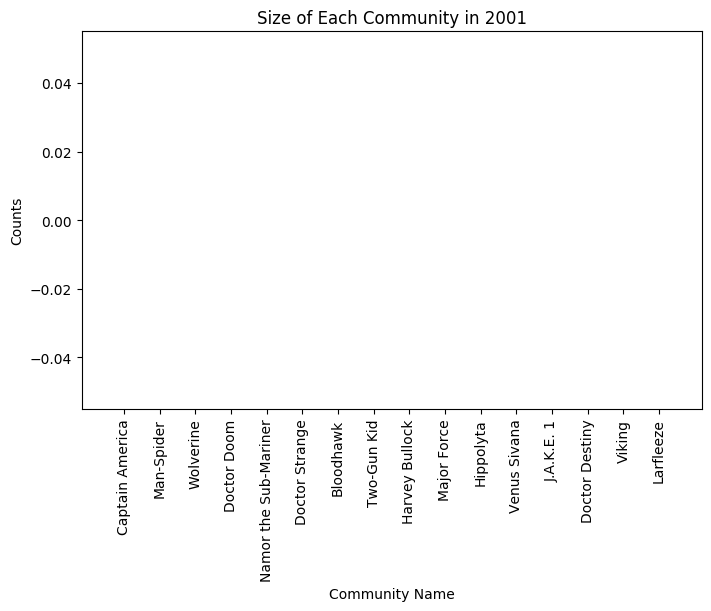

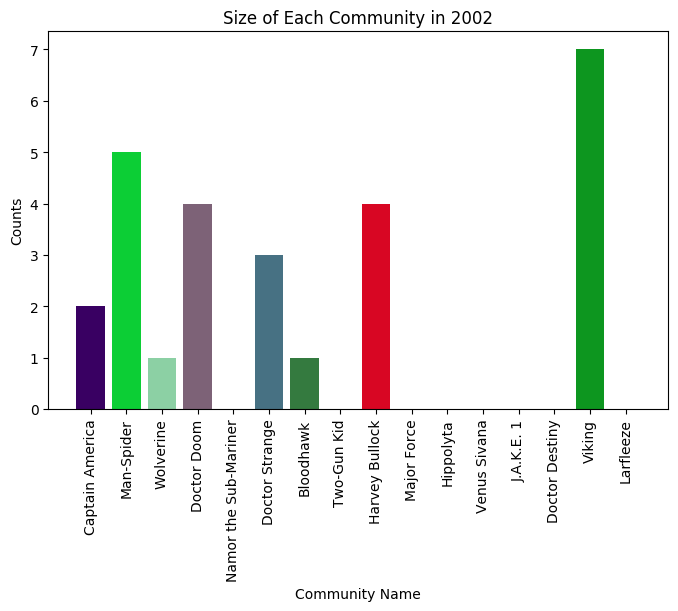

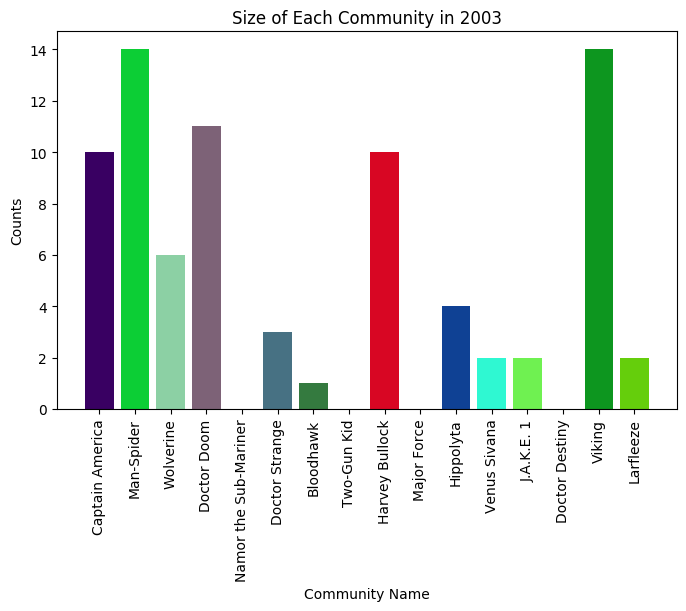

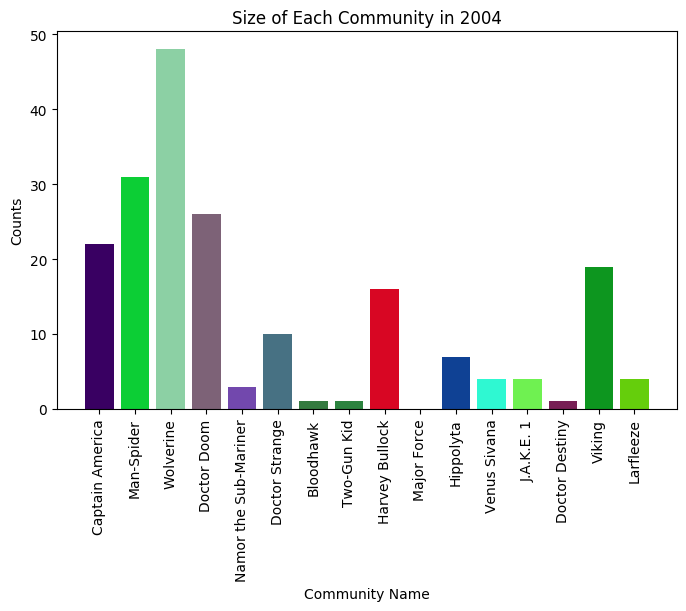

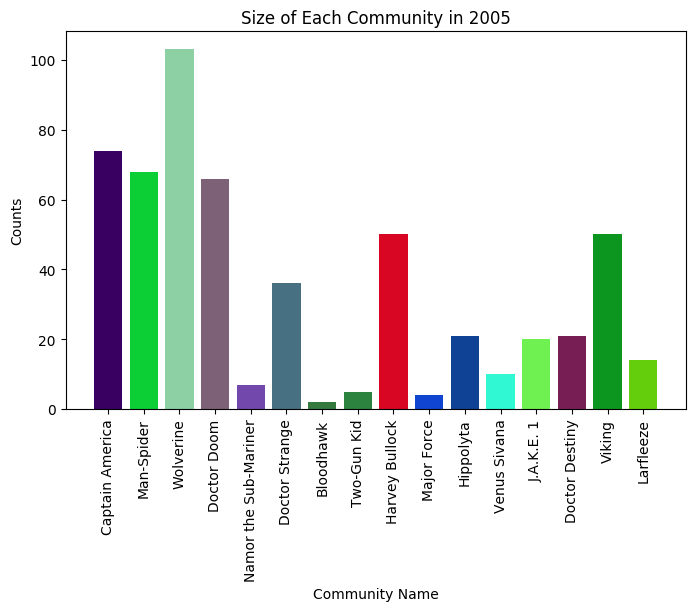

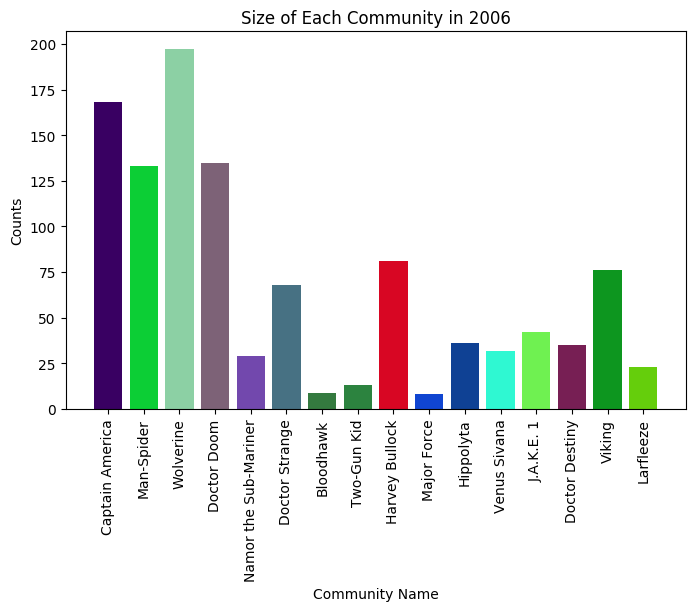

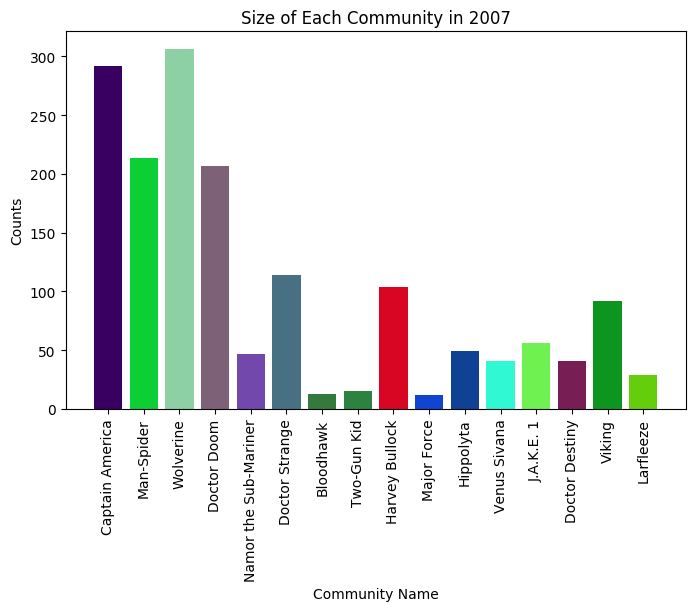

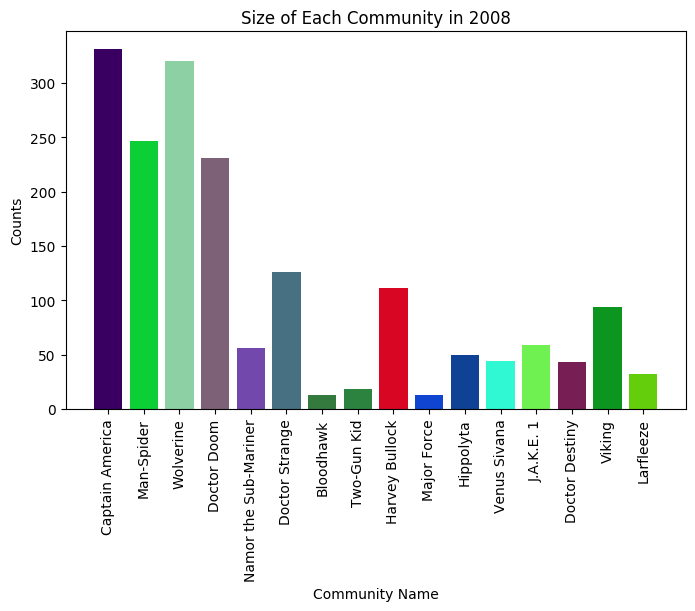

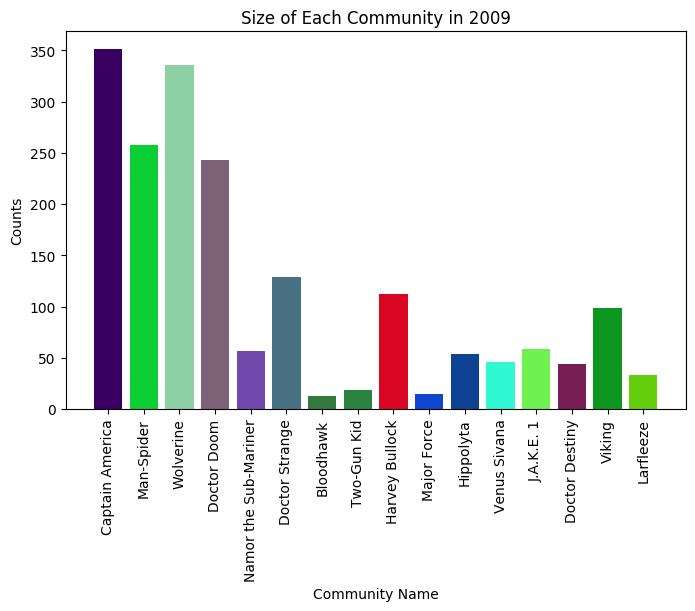

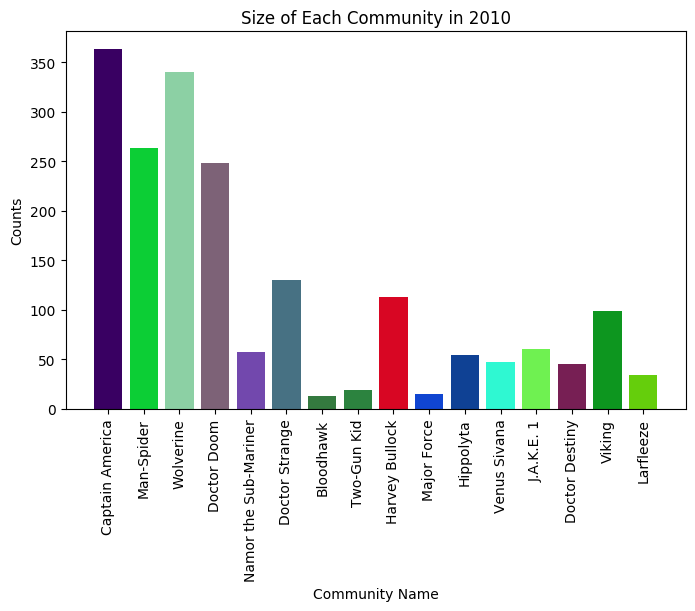

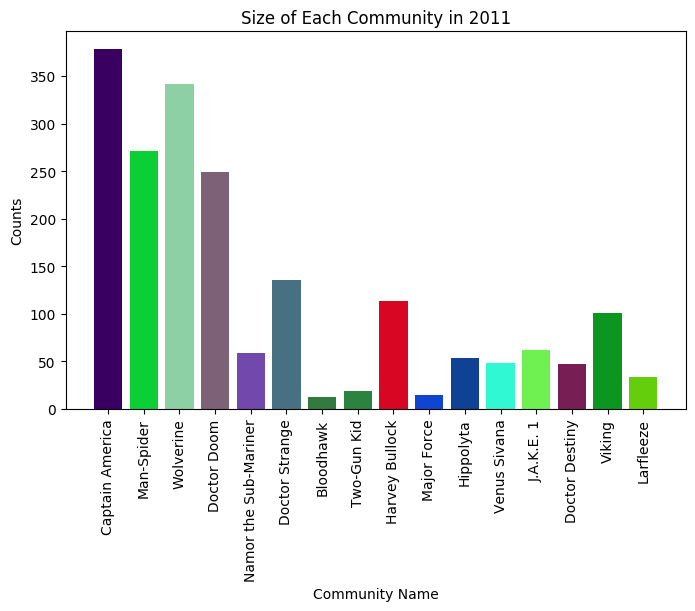

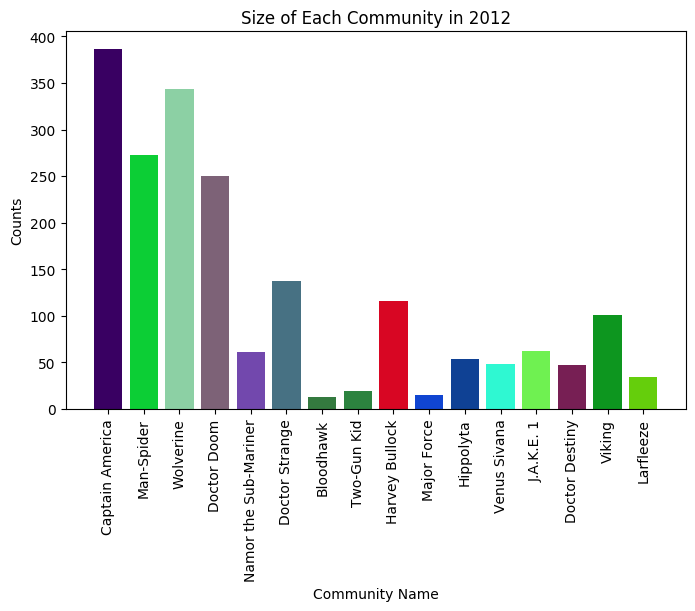

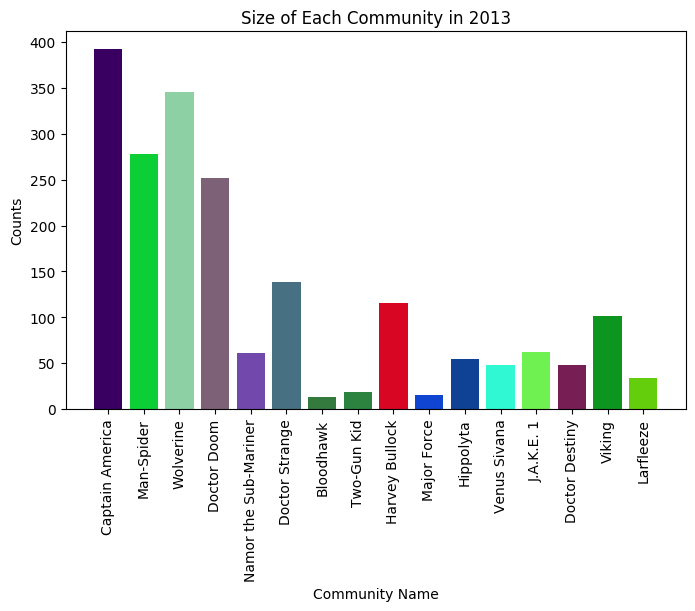

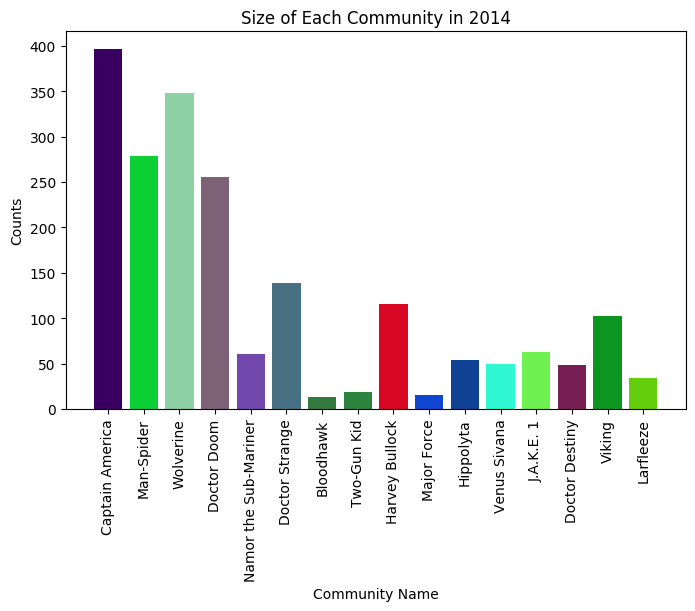

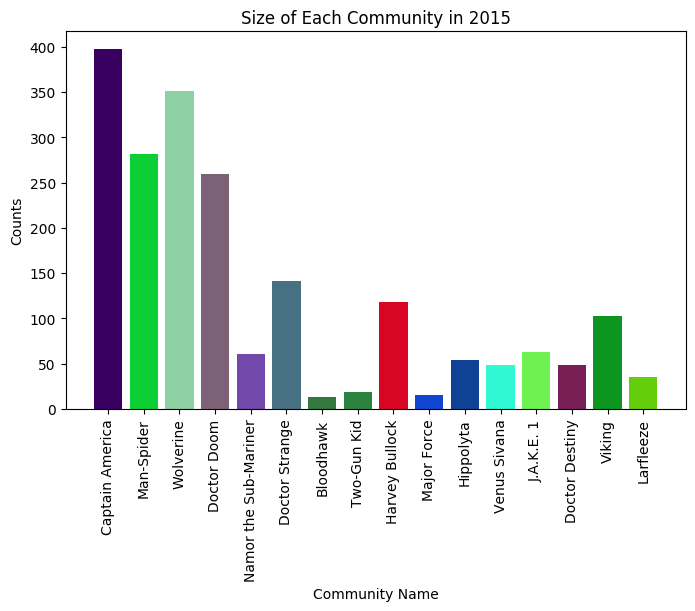

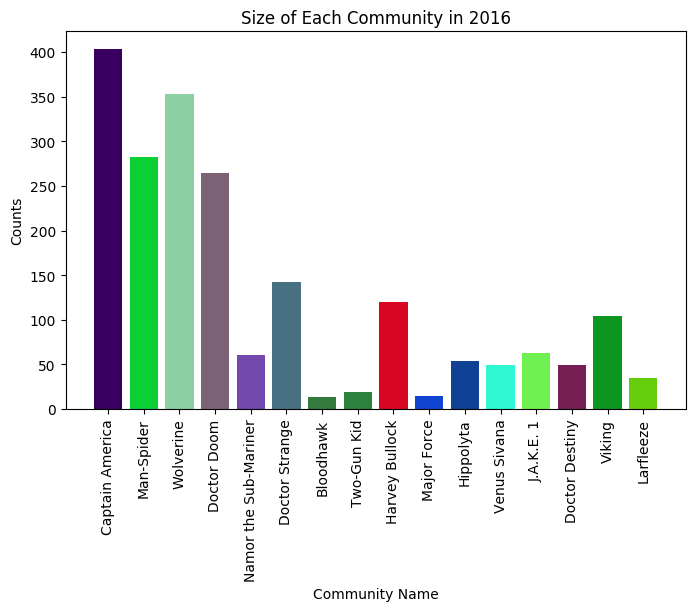

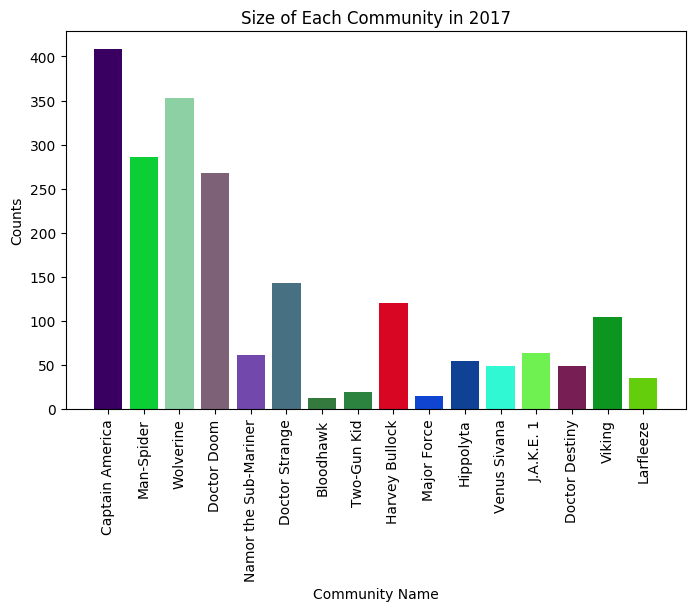

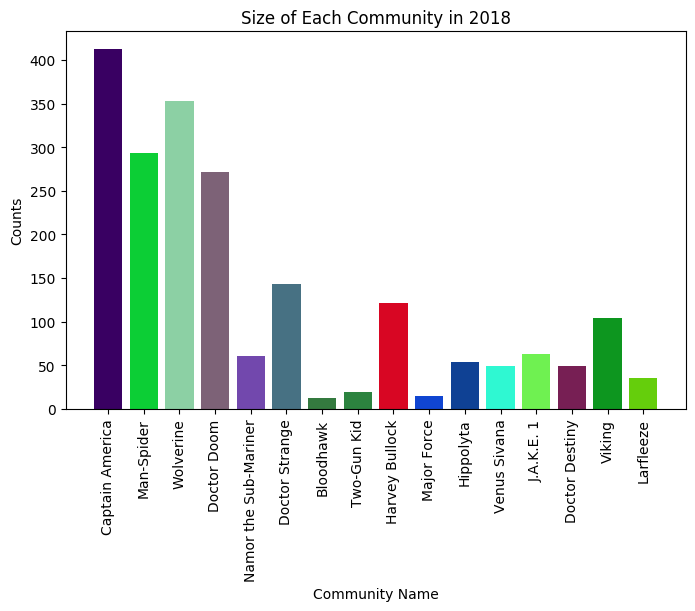

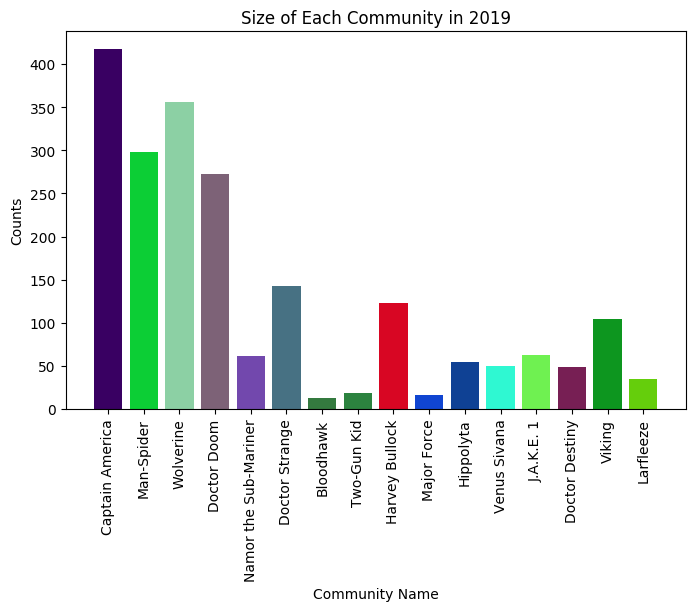

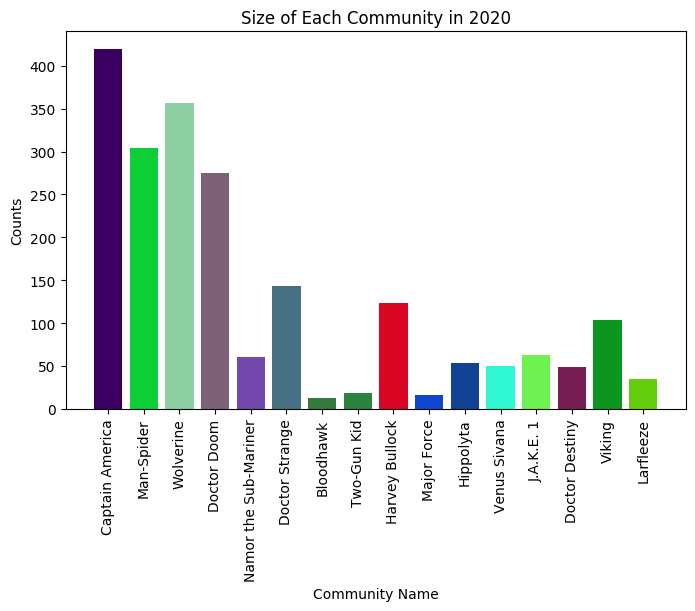

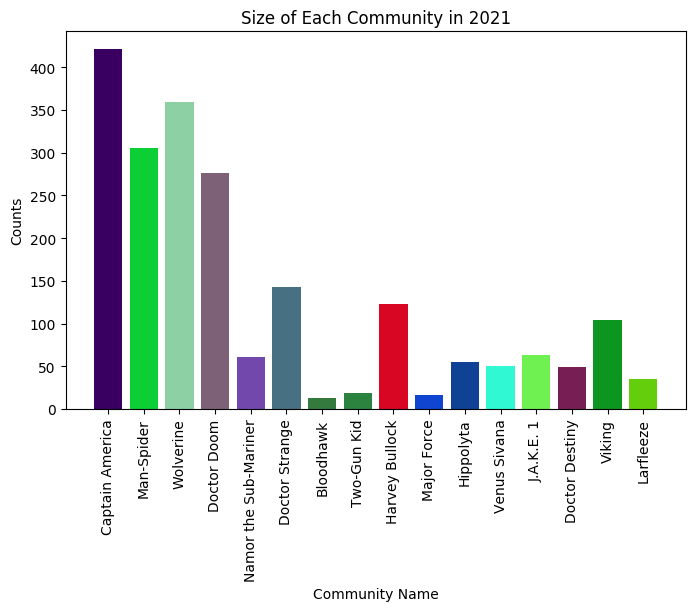

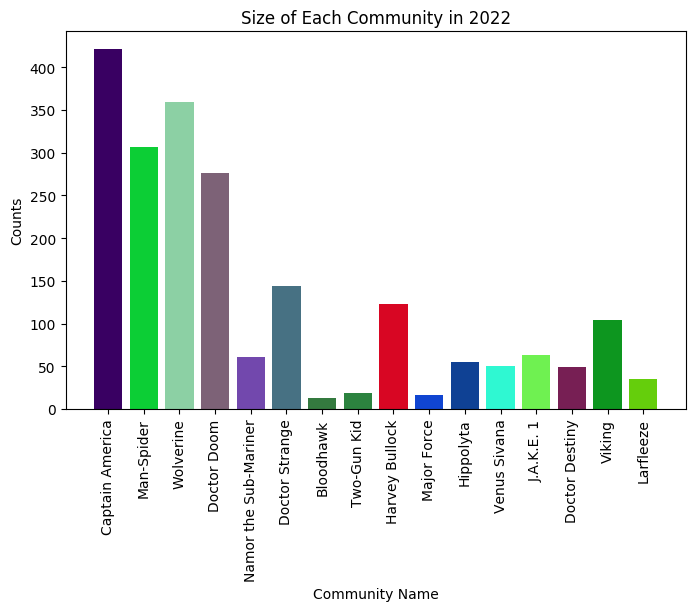

In [229]:
count = 0
for year in graphs.keys():
    fig, ax = plt.subplots(figsize=(8,5),dpi=100)
    ax.bar([list(nodes[nodes['node']==list(community_names.values())[k]]['CharacterName'])[0] for k in range(len(list(community_names.values())))], 
           partition_matrix[list(community_names.keys()),:count].sum(1),
          color=gen_colors(n_communities,42))
    ax.set_ylabel("Counts")
    ax.set_xlabel("Community Name")
    ax.set_title(f"Size of Each Community in {year}")
    plt.xticks(rotation=90)
    plt.savefig(f'plots/bar_plot_{year}.png', bbox_inches='tight')
    count+=1

In [230]:
import imageio
import os
import re

with imageio.get_writer('bar_plot_final.gif', mode='I', fps=0.5) as writer:
    for year in graphs.keys():
        image = imageio.imread(f'plots/bar_plot_{year}.png')
        writer.append_data(image)
    writer.close()

The gif looks like this:

<img src="bar_plot_final.gif" width="750" align="center">

We can see that the ratio of community sizes are quite quickly determined (Captain America being the largest and Man-Spider? being among the larger ones)